# Making the best Stocktwits account 


If I wanted to make a succesful stocktwits account in order to market my buisness to traders, what characteristics should it have?

## Web Scraper

In [ ]:
scraper() #scrapes stocktwits for posts. I ran it for about five days starting this sunday. 


## Analysis and ML

What features are associated with the top performing accounts (top ten percent in follower gain)?

In [97]:
f1,f2=17,8 #figsize parameters 
preProcessor() #cleans and preprocesses data for NLP and ML analysis. 
NaturalLanguageProcessor() #NLP processing such as stemming and sentiment analysis
stocktwitsPredictor() #ML with RandomForestClassifier 


0.972869 (0.002559)
accuracy score:  0.9727303332959264
confusion matrix:
[[7961   17]
 [ 215  718]]
Feature ranking:
1. feature 1 (0.537147)
2. feature 4 (0.160055)
3. feature 0 (0.130891)
4. feature 5 (0.108100)
5. feature 2 (0.034040)
6. feature 3 (0.029766)


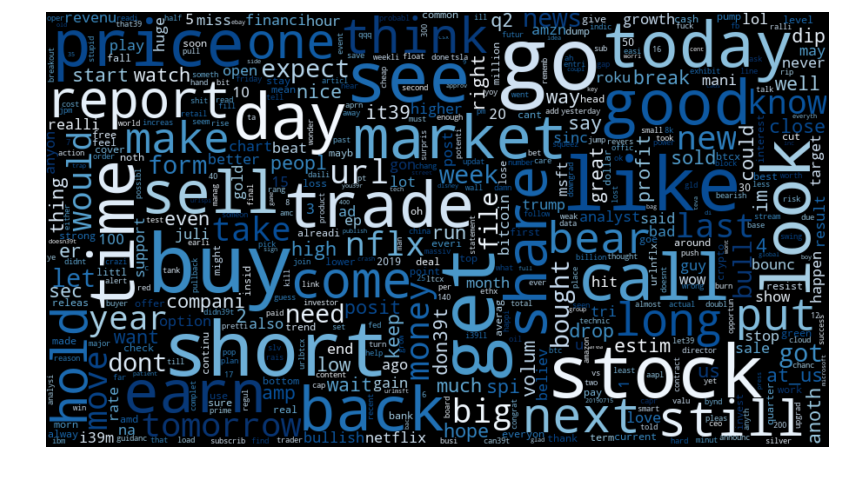

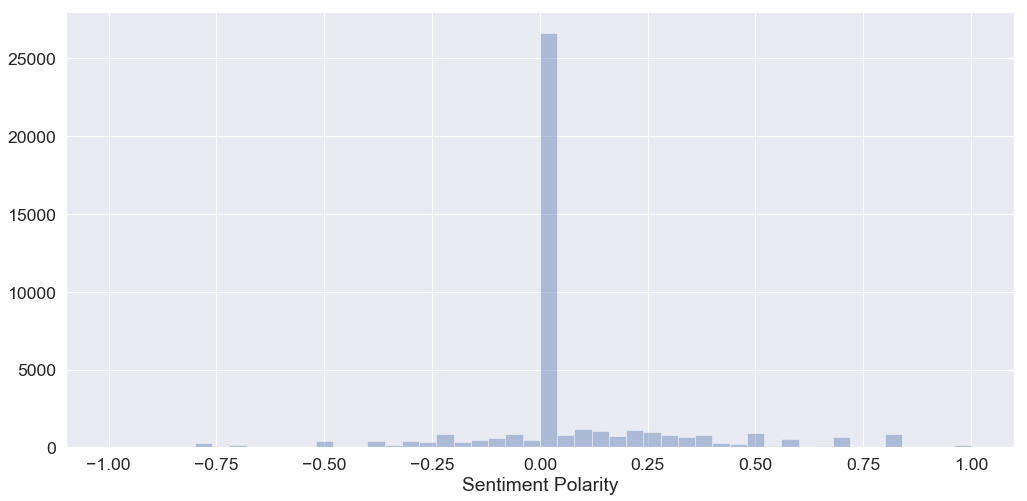

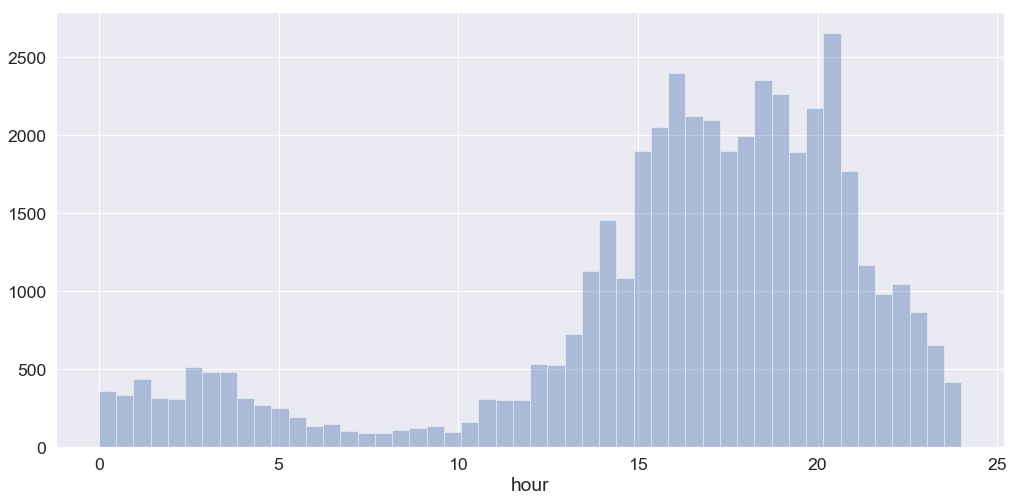

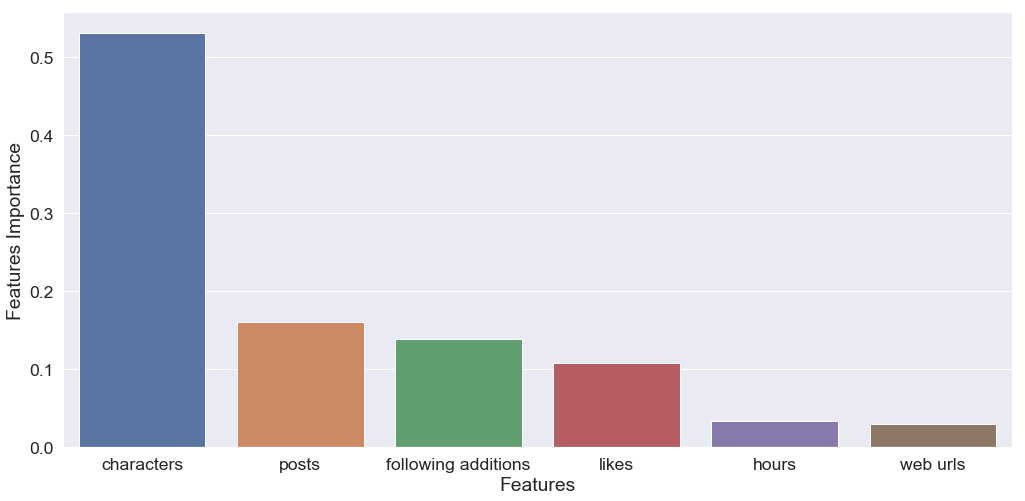

In [152]:
plotter()

## Let's see if Easymoney48's post will gain followers!

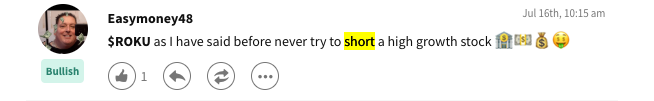

In [149]:
from IPython.display import Image

Image(filename ="easymoney.png", width=1000, height=1000)



In [153]:
df_e=df[df["user"]=="Easymoney48"]
df_e=df_e[df["created_at"]=="2019-07-16T15:15:40Z"]
x=df_e[['char_count',"posts","following_change","like_change","hour_sin","url"]]
prediction= model.predict(x)   

if prediction == 1:
   print("Easymoney48 will be in the top 10 percent!")
elif prediction == 0:
   print("Easymoney48 will not be in the top 10 percent.")

print("Easymoney48's followers gained:",df_e.iloc[0]['follower_change'] )
print("top ten percent of followers gained:",upperquantile)

Easymoney48 will not be in the top 10 percent.
Easymoney48's followers gained: 3
top ten percent of followers gained: 14.0


# Stocktwit Scraping 

In [ ]:

import requests
import time
import csv


def scraper():
    timeStep=36 # The scraper requests data from the API every 36 seconds.
    text_file = open("stocktwits.csv", "w")  

    writer=csv.writer(text_file)
    header=["user_id","user","body", "created_at","symbol","symbol_title","symbol_id","followers","following","ideas","like_count"]
    writer.writerow(header) 

    while True: #infinite loop, scraping stops until I stop it manually. 
        try:  
            request=requests.get('https://api.stocktwits.com/api/2/streams/trending.json');
            data = request.json()
            for p in data["messages"]:
                row=[p["user"]["id"],p["user"]["username"],p["body"],p["created_at"],p["symbols"][0]["symbol"],p["symbols"][0]["title"],p["symbols"][0]["id"],p["user"]["followers"],p["user"]["following"],p["user"]["ideas"],p["user"]["like_count"]]        
                writer.writerow(row) #parses JSON file into csv
            print("successful request") #announces request has been succesful. 
        except:
            print("skipping empty line") #skips empty line.          
        text_file.flush()
        time.sleep(timeStep)

            

# Data Preprocessing 

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
import nltk
import re
from nltk import ngrams, FreqDist
from nltk import sent_tokenize, word_tokenize
import string


def cleanIdeas(column):
    column=column.str.replace(r'http\S+', 'URL') #changes all "http" urls for the word url
    column=column.str.replace('@[^\s]+', 'AT_USER')#changes all the @user for a common word
    column=column.str.replace(r'[^\w\s]', '') #remove special characters
    column=column.str.lower()
    return(column)

def dateConverter(s):
     s=time.strftime("%A", time.strptime(s, "%Y-%m-%d"))
     if s=="Saturday" or s=="Sunday":
        d=1
     else:
        d=0
     return(d)

def change(s,df,label):
    column=df.loc[df["user"]==s]
    n=column[label].max()-column[label].min()
    return n
    
def preProcessor():
    filename="tweetsUser5.csv" #raw scraped data    
    df=pd.read_csv(filename) 
    df=df.drop_duplicates(); #the scraper sometimes picks up the same post, I need to drop that
    df["body"]=cleanIdeas(df["body"]) #removes irrelevant characters from the post's body
    df['char_count']=df['body'].str.len() #counts the characters in the body.
    df['posts'] = df.groupby('user')['user'].transform('count') #calculates number of posts of each user. 
    df['hour']=df['created_at'].str.slice(-9,-1) #captures the part of the string that says the hour. 
    #converts the stirng into a decimal. 
    df["hour_norm"]=pd.to_numeric(df['hour'].str[-2:])/3600+pd.to_numeric(df['hour'].str.slice(-5,-3))/60+pd.to_numeric(df['hour'].str.slice(0,2))
    #I use a sine function so that the machine learning algorithm doesn't read the interval between "0" and "24" as long. 
    df["hour_sin"]=np.sin(df["hour_norm"]/24*2*np.pi)
    df['hour_sin']=df['hour_sin'] + 1 #little hack to make "hour sin"  positive. 
    df['date']=df['created_at'].str.slice(0,-10)
    df["day"]=df["date"].apply(dateConverter)
    
    df["following_change"]=df["user"].apply(lambda x: change(x,df,"following"))
    df["follower_change"]=df["user"].apply(lambda x: change(x,df,"followers"))
    df["like_change"]=df["user"].apply(lambda x: change(x,df,"following"))




# Natural Language Processing 

In [ ]:
from nltk.stem import PorterStemmer 
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob

def ideasTokenizer(column):
    column=column.apply(word_tokenize)
    column=column.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    return(column)

def vocabCounter(tokens, wordList):
    total =  sum(map(lambda x: x in wordList, tokens))
    return total

def join_tokens(tokens):  
    return TreebankWordDetokenizer().detokenize(tokens)

def stem_sentences(tokens, porter_stemmer):
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def word_cloud(data):
    wordcloud = WordCloud(width=900,
                          height=500,
                          max_words=500,
                          max_font_size=100,
                          relative_scaling=0.5,
                          colormap='Blues').generate_from_frequencies(wordfreq)

    plt.figure(figsize=(f1,f2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def ideasJoinTokenizer(df):
    raw=''.join(df['body_stem'])
    data=word_tokenize(raw);
    return(data)

def polarity(s):
    blob=TextBlob(s)
    return(blob.sentiment.polarity)

def subjectivity(s):
    blob=TextBlob(s)
    return(blob.sentiment.subjectivity)

def NaturalLanguageProcessor():
    porter_stemmer = PorterStemmer()
    #list of technical words in word cloud
    technicalList=["day","time","price","short","sell","share","stock","bitcoin","bear","bull","year","today","volum","long","hold","week","move","earn","money","high","low","crypto","chart","profit","financi"]  
    df["body_tokens"]=ideasTokenizer(df["body"])
    df['body_tokens'] = df['body_tokens'].apply(lambda x: stem_sentences(x,porter_stemmer))     #stemming 
    df['key_words'] = df['body_tokens'].apply(lambda x: vocabCounter(x,technicalList))
    df['url'] = df['body_tokens'].apply(lambda x: vocabCounter(x,["url"])) #number of url occurences in a post
    df['body_stem'] = df["body_tokens"].apply(join_tokens) #join stemmed tokens into posts
    data=ideasJoinTokenizer(df) #join all posts into a single string.   
    df["polarity"]=df["body_stem"].apply(polarity) #NLP sentiment analysis on polarity
    df["subjectivity"]=df["body_stem"].apply(subjectivity) #NLP sentiment analysis on subjectivity
    




# Predicting Succesful Stocktwit Account with ML

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore") #warnings in this case are about new updates changing parameters, not flaws in code

def stocktwitsPredictor():

    upperquantile=df["follower_change"].quantile(q=0.9) #we count only the top 10 percent in followers as succesful users
    df.loc[df['follower_change'] >= upperquantile, 'viable'] = 1
    df.loc[df['follower_change'] < upperquantile, 'viable'] = 0

     model= RandomForestClassifier()
    X_train, X_test, y_train, y_test = train_test_split(df[['char_count',"posts","following_change","like_change","hour_sin","url"]], df['viable'], test_size=0.2)

    scoring = 'accuracy'
    kfold =KFold(n_splits=10) #cross validation of 10 splits
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
    print(msg)
    model = model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    print('accuracy score: ',accuracy_score(y_test, y_preds))
    print('confusion matrix:')
    print(confusion)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [138]:
def barPlotFeatures():
    x=range(X_train.shape[1])
    x=['characters','posts','following additions','likes','hours',"web urls"]
    y=importances[indices]
    fig, ax = plt.subplots(figsize=(f1,f2))
    ax.set_ylabel("Features Importance")
    ax.set_xlabel("Features")
    sns.barplot(x,y,orient ="v")
    
    
    


# Plotting

In [134]:
def plotter():
    #print(df.shape)
    word_cloud(data)
    sns.set(font_scale = 1.6)
    plt.figure(figsize=(f1, f2))
    sns.distplot(df['polarity'],kde=False)
    plt.xlabel("Sentiment Polarity")
    plt.figure(figsize=(f1, f2))
    sns.distplot(df['hour_norm'],kde=False)
    plt.xlabel("hour")
    barPlotFeatures()
